# EE 605 Digital Image Processing
# Assignment_1
#### -Karan Khajanchi (21110096)  <br>
**Note:** In this assignment, all matrix and math operations performed with NumPy. The implementation primarily relies on fundamental mathematics and utilizes basic for and while loops. I have leveraged the Numba library, which uses JIT-compilation to speed up the operations, and achieve faster runtimes. No additional advanced libraries have been employed in the process.
## Q1. Non Local Means (NLM) Denoising
Firstly we import the required libraries.

In [1]:
import numpy as np
import numba
import cv2
import math
import matplotlib.pyplot as plt
%matplotlib inline 

Now, we import the images, using the imread function of cv2.

In [103]:
image1 = cv2.imread("NLM\image1.png", 0) 
image2 = cv2.imread("NLM\image2.png", 0)
image3 = cv2.imread("NLM\image3.png", 0) 
image4 = cv2.imread("NLM\image4.png", 0)
new_size = (384, 256)
image1 = cv2.resize(image1, new_size)
image2 = cv2.resize(image2, new_size)
image3 = cv2.resize(image3, new_size)

Now, we define a function to add noise to the image, by adding additive white Gaussian noise with mean 0 and standard deviationsigma..

In [52]:
def add_noise(img,stddev):
    mean = 0
    stddev = stddev/255
    img = img/255
    result = img.copy()
    gauss = np.random.normal(mean, stddev, img.shape)
    result = result + gauss
    result = np.clip(result, 0, 1)
    # Converting the result back to uint8
    result = np.uint8(result*255)
    return result

Now, we define a function to compute the squared euclidian distance between I(p) and I(q).

In [53]:
@numba.jit(nopython=True)
def sed(img,sub_img1,qi,qj,f):
    sub_img2 = img[qi-f:qi+f, qj-f:qj+f]
    #Now we take the difference of both the square matrices and then square the individual elements of the resultant matrix
    res_mat = sub_img1 - sub_img2
    res_mat = res_mat**2
    sum = np.sum(res_mat)
    #Normalize the sum
    sum = sum * (1/((2*f + 1)**2))
    return sum

Now, we define a function to compute the weight w(p,q) between I(p) and I(q), using the function mentioned.

In [54]:
@numba.jit(nopython=True)
def wx(d,stddev,h):
    result = np.exp(-max(d - stddev**2,0)/h**2)
    return result

Now, we define a function which performs denoising of one pixel located at (i,j), by implementing the NL-means algorithm.<br>

B(p, r) is the research window indicating a neighbourhood centered at p with the size (2r + 1) × (2r + 1) pixels. h is the filtering parameter set depending on the value of sigma. Arguments such stddev, r, f, and h are passed which are used for calculating the weights and squared euclidian distance of different pixels, using the functions defined above. ***Special care is taken to set the weight of the reference pixel p in the average, as the maximum of the weights in the 
neighborhood B(p, r)***.

In [55]:
@numba.jit(nopython=True)
def nlm(img,i,j,r,f,stddev,h):
    sub_img1 = img[i-f:i+f, j-f:j+f]
    sum = 0
    maxi = 0
    res = 0
    for row in range(i-r,i+r+1):
        for col in range(j-r,j+r+1):
            if row==i and col==j: #for pixel location p we do not calculate the wieght, we will set it as the max value of window later.
                continue
            else:
                d = sed(img,sub_img1,row,col,f)
                weight = wx(d,stddev,h)
                res += weight*img[row][col]
                sum += weight
                maxi = max(maxi,weight)

    #setting the pixel p's weight as the maximum in the neighbourhood
    res += maxi*img[i][j]
    sum += maxi
    #normalizing the result
    res /= sum
    return res

Using the function above, we are ready to perform denoising of the entire image. We also pad the image with zeros (r+f) distance on each edge. We 

In [94]:
def denoise(img,r,f,stddev,h):
    padded_img = np.pad(img, ((r+f, r+f), (r+f, r+f)), mode='reflect')
    final_img = np.zeros_like(img)
    n = len(img)
    m = len(img[0])
    for i in range(n):
        for j in range(m):
             final_img[i][j] = nlm(padded_img,r+f+i,r+f+j,r,f,stddev,h)
    return final_img

In [95]:
def MSE(image1,image2):
    mse = np.mean(np.square(image1.astype(float) - image2.astype(float)))
    return mse

def RMSE(image1,image2):
    return np.sqrt(MSE(image1,image2))
    
def PSNR(image1, image2, peak=255):
    # Calculating the Mean Squared Error
    mse = MSE(image1,image2)
    # Calculating the Peak Signal Noise Ratio
    psnr = 10*np.log10(peak**2/mse)
    return psnr

In [96]:
stddev1, stddev2, stddev3 = 15, 45, 80      #standard deviation = 15, 45, 80, according to the question
r1, r2 = 10, 17                             #research window: small window 21x21,r=10 and moderate window 35x35,r=17
k1, k2, k3 = 0.01, 0.40, 0.65                         #0.01 ≤ k ≤ 0.65
#h = k*stddev                                #h is the filtering parameter
f1, f2, f3 = 3, 5, 7                        #comparison window (2f + 1)x(2f + 1).... f=3,5,7

In [105]:
noise1_img1 = add_noise(image1,stddev1)
noise2_img1 = add_noise(image1,stddev2)
noise3_img1 = add_noise(image1,stddev3)
res1_img1 = denoise(noise1_img1,r1,f1,stddev1,k2*stddev1)
res2_img1 = denoise(noise2_img1,r1,f2,stddev2,k2*stddev2)
res3_img1 = denoise(noise3_img1,r2,f3,stddev3,k3*stddev3)
diff11 = image1 - res1_img1
diff12 = image1 - res2_img1
diff13 = image1 - res3_img1
print("Results:")
print("Sigma=15: " + "RMSE= " + str(RMSE(image1,res1_img1)) + " PSNR= " + str(PSNR(image1,res1_img1)))
print("Sigma=45: " + "RMSE= " + str(RMSE(image1,res2_img1)) + " PSNR= " + str(PSNR(image1,res2_img1)))
print("Sigma=80: " + "RMSE= " + str(RMSE(image1,res3_img1)) + " PSNR= " + str(PSNR(image1,res3_img1)))

Results:
Sigma=15: RMSE= 28.8857477615994 PSNR= 18.917131317723516
Sigma=45: RMSE= 39.23740348435419 PSNR= 16.256798399927227
Sigma=80: RMSE= 34.23043687769542 PSNR= 17.44255476856742


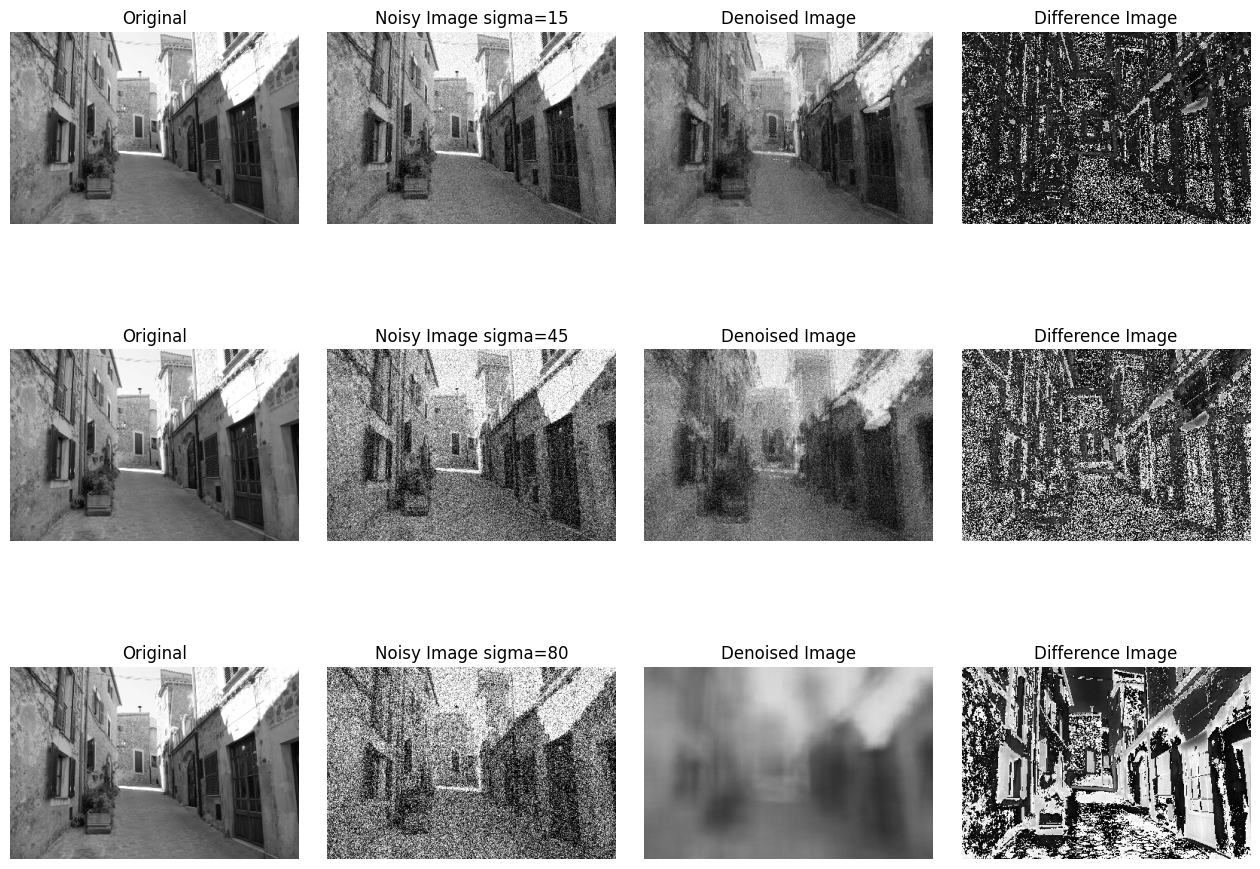

In [110]:
fig, axs = plt.subplots(3, 4, figsize=(16, 12))
axs[0, 0].imshow(image1, cmap='gray', vmin=0, vmax=255)
axs[0, 0].set_title('Original')
axs[0, 1].imshow(noise1_img1, cmap='gray', vmin=0, vmax=255)
axs[0, 1].set_title('Noisy Image sigma=15')
axs[0, 2].imshow(res1_img1, cmap='gray', vmin=0, vmax=255)
axs[0, 2].set_title('Denoised Image')
axs[0, 3].imshow(diff11, cmap='gray', vmin=0, vmax=255)
axs[0, 3].set_title('Difference Image')

axs[1, 0].imshow(image1, cmap='gray', vmin=0, vmax=255)
axs[1, 0].set_title('Original')
axs[1, 1].imshow(noise2_img1, cmap='gray', vmin=0, vmax=255)
axs[1, 1].set_title('Noisy Image sigma=45')
axs[1, 2].imshow(res2_img1, cmap='gray', vmin=0, vmax=255)
axs[1, 2].set_title('Denoised Image')
axs[1, 3].imshow(diff12, cmap='gray', vmin=0, vmax=255)
axs[1, 3].set_title('Difference Image')

axs[2, 0].imshow(image1, cmap='gray', vmin=0, vmax=255)
axs[2, 0].set_title('Original')
axs[2, 1].imshow(noise3_img1, cmap='gray', vmin=0, vmax=255)
axs[2, 1].set_title('Noisy Image sigma=80')
axs[2, 2].imshow(res3_img1, cmap='gray', vmin=0, vmax=255)
axs[2, 2].set_title('Denoised Image')
axs[2, 3].imshow(diff13, cmap='gray', vmin=0, vmax=255)
axs[2, 3].set_title('Difference Image')

for ax in axs.ravel():
    ax.axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

In [108]:
noise1_img2 = add_noise(image2,stddev1)
noise2_img2 = add_noise(image2,stddev2)
noise3_img2 = add_noise(image2,stddev3)
res1_img2 = denoise(noise1_img2,r1,f1,stddev1,k2*stddev1)
res2_img2 = denoise(noise2_img2,r1,f2,stddev2,k2*stddev2)
res3_img2 = denoise(noise3_img2,r2,f3,stddev3,k3*stddev3)
diff21 = image2 - res1_img2
diff22 = image2 - res2_img2
diff23 = image2 - res3_img2
print("Results:")
print("Sigma=15: " + "RMSE= " + str(RMSE(image2,res1_img2)) + " PSNR= " + str(PSNR(image2,res1_img2)))
print("Sigma=45: " + "RMSE= " + str(RMSE(image2,res2_img2)) + " PSNR= " + str(PSNR(image2,res2_img2)))
print("Sigma=80: " + "RMSE= " + str(RMSE(image2,res3_img2)) + " PSNR= " + str(PSNR(image2,res3_img2)))

Results:
Sigma=15: RMSE= 31.239098847335846 PSNR= 18.236833662367825
Sigma=45: RMSE= 40.74500317351842 PSNR= 15.929316489357461
Sigma=80: RMSE= 39.13972795566366 PSNR= 16.27844755411718


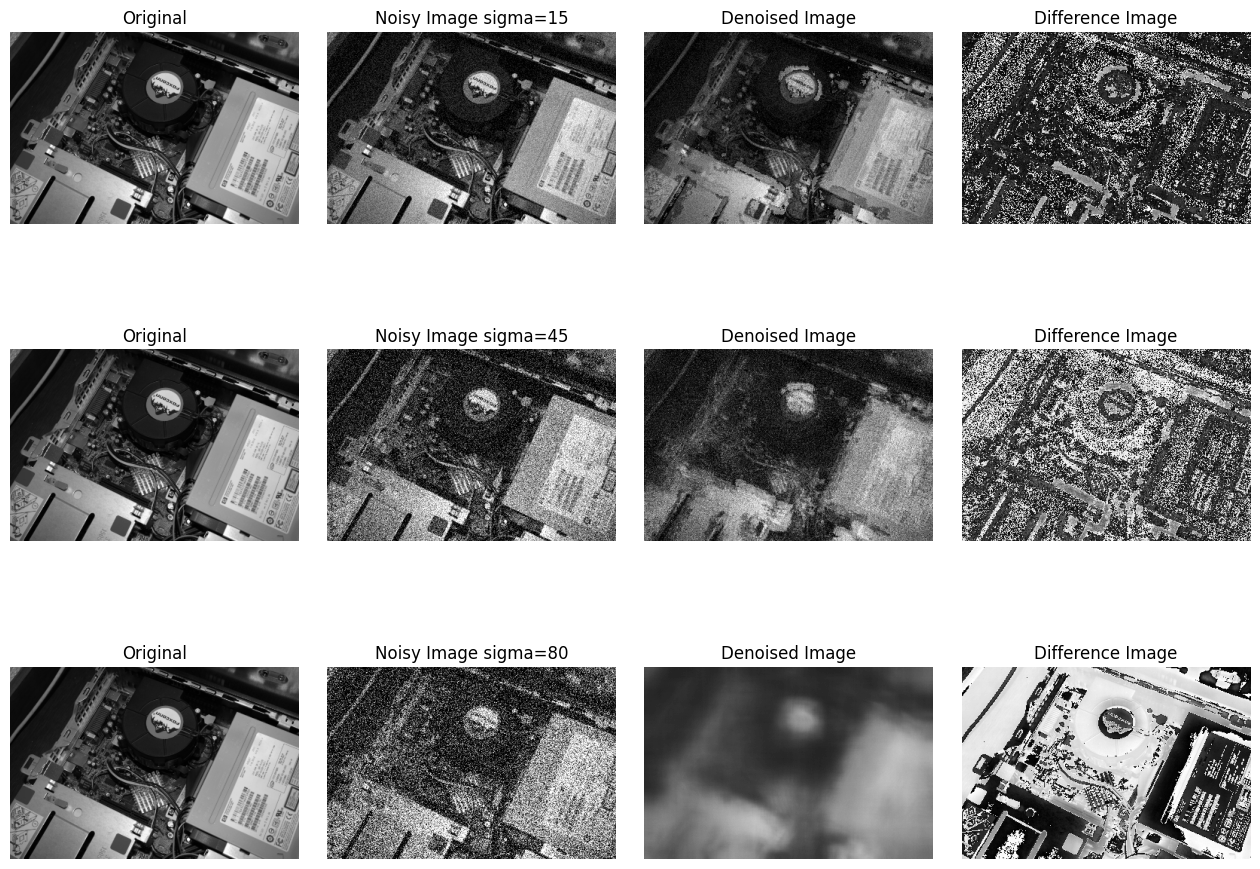

In [109]:
fig, axs = plt.subplots(3, 4, figsize=(16, 12))
axs[0, 0].imshow(image2, cmap='gray', vmin=0, vmax=255)
axs[0, 0].set_title('Original')
axs[0, 1].imshow(noise1_img2, cmap='gray', vmin=0, vmax=255)
axs[0, 1].set_title('Noisy Image sigma=15')
axs[0, 2].imshow(res1_img2, cmap='gray', vmin=0, vmax=255)
axs[0, 2].set_title('Denoised Image')
axs[0, 3].imshow(diff21, cmap='gray', vmin=0, vmax=255)
axs[0, 3].set_title('Difference Image')

axs[1, 0].imshow(image2, cmap='gray', vmin=0, vmax=255)
axs[1, 0].set_title('Original')
axs[1, 1].imshow(noise2_img2, cmap='gray', vmin=0, vmax=255)
axs[1, 1].set_title('Noisy Image sigma=45')
axs[1, 2].imshow(res2_img2, cmap='gray', vmin=0, vmax=255)
axs[1, 2].set_title('Denoised Image')
axs[1, 3].imshow(diff22, cmap='gray', vmin=0, vmax=255)
axs[1, 3].set_title('Difference Image')

axs[2, 0].imshow(image2, cmap='gray', vmin=0, vmax=255)
axs[2, 0].set_title('Original')
axs[2, 1].imshow(noise3_img2, cmap='gray', vmin=0, vmax=255)
axs[2, 1].set_title('Noisy Image sigma=80')
axs[2, 2].imshow(res3_img2, cmap='gray', vmin=0, vmax=255)
axs[2, 2].set_title('Denoised Image')
axs[2, 3].imshow(diff23, cmap='gray', vmin=0, vmax=255)
axs[2, 3].set_title('Difference Image')

for ax in axs.ravel():
    ax.axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

#### Conclusion
There is still room for improvement in the implementation of the non-local means algorithm.
- As visible from the output, the algorithm performs poorly for noises having higher sigma (80).
- From the calculated values of RMSE and PSNR, the RMSE seems to be between 20 and 40 which is not very good, and the PSNR values are ranging between 15 to 20 which is decent, but not quite acceptable.
- The difference image indicates that denoising has resulted in a significant loss of detail, providing clear evidence that there is ample room for improvement.

## Q2. Histogram Matching
Firstly, we import the required libraries.

In [10]:
import numpy as np
import numba
import cv2
import math
import matplotlib.pyplot as plt
%matplotlib inline 

Now, we import the image, using the imread function of cv2.

In [11]:
img1 = cv2.imread("histogram_matching\grey_1.png", 0)
img2 = cv2.imread("histogram_matching\grey_2.png", 0) 
img3 = cv2.imread("histogram_matching\grey_3.png", 0) 
img4 = cv2.imread("histogram_matching\grey_4.png", 0) 

Let's define a function which calculates the histogram of an image. For this we first create an empty array of size 256. Each index will store the frequency of the pixels having the grey level as the index.

In [12]:
@numba.jit(nopython=True)
def hist(img):
    hist = np.zeros(256)
    for i in range(len(img)):
        for j in range(len(img[0])):
            hist[img[i][j]] += 1
    return hist

Now, we define a function which matches histogram of images A and B. Let the continuous gray levels *r* and *z*  and let *p_r(r)* and *p_z(z)* denote their corresponding 
continuuos probability density functions.For this we first calculate the equalized histogram transformations of both the images given. This is done by simply calculating the cumulative distribution function of the histogram (discrete) and then normalingze the resulting function so that the values range from 0 to 255. Let's call the first transformation as) *T(r)* and the second transformation as)*G(z)*

Now, let's call it *s_k*, the mapping of *r_k* in *T*. Thus, all we have to do to find the value of z_k 
corresponding to sk. This is done by iterating on values of z such that this equation is satisfiedf
o*   k=0, 1, 2, p ,L. <br>
**G(z) - sk >= 0** <br>

#### NOTE:  This is thesame  implementation of the algorithm for histogram matching given in section *3.3.2 Histogram Matching (Specification)* of the book *Digital Image processing using MATLAB (2002, Pearson_Prentice Hall)*, authored by *Rafael C. Gonzalez, Richard E. Woods, Steven L. Eddins*.-1. 

In [13]:
@numba.jit(nopython=True)
def hist_match(img1,img2):
    hist1 = hist(img1)
    hist2 = hist(img2)
    
    #we calculate the cumulative sum using the cumsum() function in numpy
    cdf1 = hist1.cumsum() 
    cdf2 = hist2.cumsum()
    T = ((cdf1) * 255 / (np.max(cdf1))).astype(np.uint8) # = cdf1_normalized
    G = ((cdf2) * 255 / (np.max(cdf2))).astype(np.uint8) # = cdf2_normalized
    
    #converting to dtype int16 so that when we later take difference between the values, we can get a negative integer
    T = T.astype(np.int16) 
    G = G.astype(np.int16)

    mapping = np.zeros(256)
    z=0
    for k in range(256):
        while (z<256):
            if (G[z]-T[k]<0):
                z += 1
            else:
                break
        mapping[k] = z

    #Now we just map each pixel of the image through the new mapping scheme we computed
    matched_image = np.zeros_like(img1)
    for i in range(len(img1)):
        for j in range(len(img1[0])):
            matched_image[i][j] = mapping[img1[i][j]]

    return matched_image

Now, we call the function and perform the histogram matching. The following combinations of source and target combinations are given in the question.

In [14]:
res1 = hist_match(img1, img2)
res2 = hist_match(img4, img3)
res3 = hist_match(img2, img4)
res4 = hist_match(img3, img1)

After this we plot the source, target and matched images side by side to observe the changes.

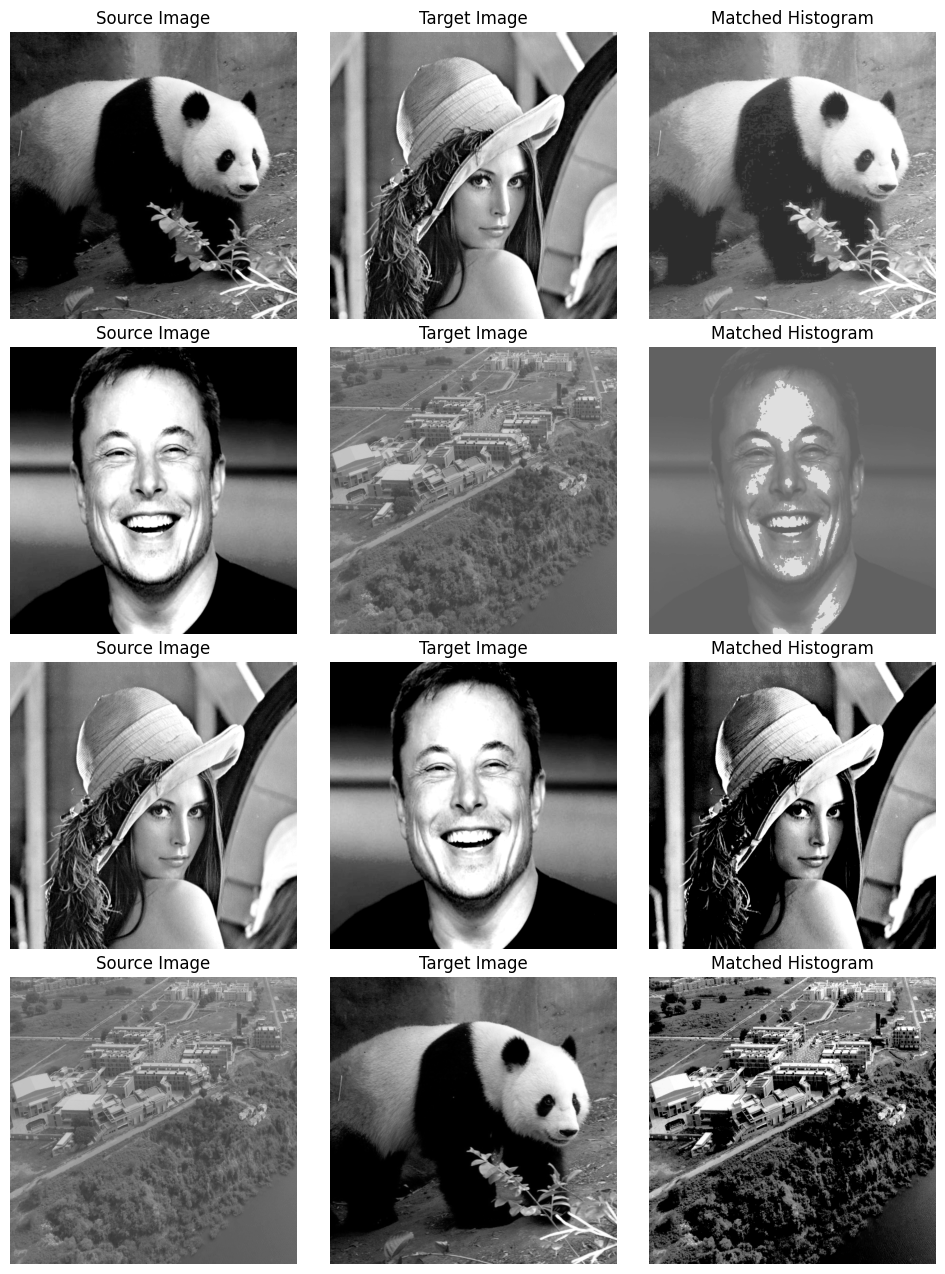

In [15]:
fig, axs = plt.subplots(4, 3, figsize=(12, 16))

axs[0, 0].imshow(img1, cmap='gray', vmin=0, vmax=255)
axs[0, 0].set_title('Source Image')
axs[0, 1].imshow(img2, cmap='gray', vmin=0, vmax=255)
axs[0, 1].set_title('Target Image')
axs[0, 2].imshow(res1, cmap='gray', vmin=0, vmax=255)
axs[0, 2].set_title('Matched Histogram')

axs[1, 0].imshow(img4, cmap='gray', vmin=0, vmax=255)
axs[1, 0].set_title('Source Image')
axs[1, 1].imshow(img3, cmap='gray', vmin=0, vmax=255)
axs[1, 1].set_title('Target Image')
axs[1, 2].imshow(res2, cmap='gray', vmin=0, vmax=255)
axs[1, 2].set_title('Matched Histogram')

axs[2, 0].imshow(img2, cmap='gray', vmin=0, vmax=255)
axs[2, 0].set_title('Source Image')
axs[2, 1].imshow(img4, cmap='gray', vmin=0, vmax=255)
axs[2, 1].set_title('Target Image')
axs[2, 2].imshow(res3, cmap='gray', vmin=0, vmax=255)
axs[2, 2].set_title('Matched Histogram')

axs[3, 0].imshow(img3, cmap='gray', vmin=0, vmax=255)
axs[3, 0].set_title('Source Image')
axs[3, 1].imshow(img1, cmap='gray', vmin=0, vmax=255)
axs[3, 1].set_title('Target Image')
axs[3, 2].imshow(res4, cmap='gray', vmin=0, vmax=255)
axs[3, 2].set_title('Matched Histogram')

for ax in axs.ravel():
    ax.axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

#### Conclusion
The histogram matching results look satisfactory.
- In the first result, it has the histogram profile of the target image, making it look duller than the original image.
- In the second result, it has the histogram profile of the target image, making it look duller and washed out than the original image.
- In the third result, it has the histogram profile of the target image, making it look darker than the original image.
- In the fourth result, it has the histogram profile of the target image, making it look darker than the original image.

The results prove the successful implementation of the histogram matching (specification) algorithm.